# Home Energy Management with Dynamic Tariffs and Peak Power Charges

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import calendar
import tqdm

# Customize plot settings
from latexify import *
from utils import *
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio
latexify(fig_width=5)

## Problem data

In [2]:
load_data = pd.read_csv('data/loads.csv', parse_dates=[0], index_col=0)["Load (kW)"]
MIN, MAX = load_data.min(), load_data.max()
tou_price_data = pd.read_csv('data/tou_prices.csv', parse_dates=[0], index_col=0)["TOU Price (NOK/kWh)"]
spot_price_data = pd.read_csv('data/spot_prices.csv', parse_dates=[0], index_col=0)["Spot Price (NOK/kWh)"]

# Load forecasting
load_baseline = pd.read_csv('data/load_baseline.csv', parse_dates=[0], index_col=0)["Baseline load (kW)"]
AR_params = pd.read_pickle("data/AR_params.pickle")
sigma_residual_errors = pd.read_pickle("data/sigma_residual_errors.pickle")

# Define simulation window: one year (2022) with hourly resolution
T = 24 * 365
start_date = pd.Timestamp("2022-01-01 00:00:00", tz=None)

sim_start_time = load_baseline.index.get_loc(start_date)
sim_end_time = sim_start_time + T
sim_datetime_index = load_data.index[sim_start_time:sim_end_time]

# Load and price values for 2022
load = load_data.iloc[sim_start_time:sim_end_time].values
tou_prices = tou_price_data.iloc[sim_start_time:sim_end_time].values
spot_prices = spot_price_data.iloc[sim_start_time:sim_end_time].values

## Baseline analysis: no storage

Total cost: 24,722.07 NOK
	Energy cost related to time-of-use prices: 8,676.61 NOK (35.10% of total cost)
	Energy cost related to day-ahead spot prices: 13,336.45 NOK (53.95% of total cost)
	Peak power cost: 2,709.00 NOK (10.96% of total cost)



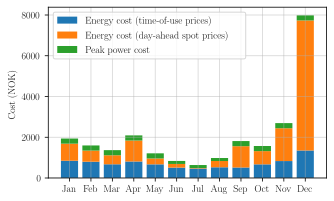

In [3]:
monthly_tou_costs, monthly_spot_costs, monthly_peak_costs, tou_cost, spot_cost, peak_cost = compute_costs(tou_prices, spot_prices, load, sim_datetime_index)
cost_no_storage = tou_cost + spot_cost + peak_cost
print_cost_summary(tou_cost, spot_cost, peak_cost)

# Plot monthly cost breakdown
fig, ax = plt.subplots()
bar_width = 0.8
months = np.arange(1, 13)
plt.bar(months, monthly_tou_costs, bar_width, color="tab:blue", label='Energy cost (time-of-use prices)')
plt.bar(months, monthly_spot_costs, bar_width, bottom=monthly_tou_costs, color="tab:orange", label='Energy cost (day-ahead spot prices)')
plt.bar(months, monthly_peak_costs, bar_width, bottom=[i+j for i,j in zip(monthly_tou_costs, monthly_spot_costs)], color="tab:green", label='Peak power cost')
plt.xticks(months, [calendar.month_abbr[m] for m in range(1, 13)])
plt.ylabel('Cost (NOK)')
plt.legend()
plt.savefig("figures/cost_no_storage.pdf")

## Prescient problem (perfect foresight)

In [4]:
# Solution via MICP solver (e.g., GUROBI)
p_prescient, q_prescient, _, _, cost_prescient, _, = optimize(load=load, tou_prices=tou_prices, spot_prices=spot_prices, T=T, datetime_index=sim_datetime_index, N=3)

## Solution via relax-and-resolve strategy
# p_prescient, q_prescient, _, _, cost_prescient, _ = relax_and_resolve(load=load, tou_prices=tou_prices, spot_prices=spot_prices, T=T, datetime_index=sim_datetime_index)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-13


Total cost: 21,188.23 NOK
	Energy cost related to time-of-use prices: 8,365.10 NOK (39.48% of total cost)
	Energy cost related to day-ahead spot prices: 11,018.14 NOK (52.00% of total cost)
	Peak power cost: 1,805.00 NOK (8.52% of total cost)



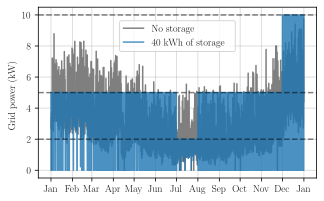

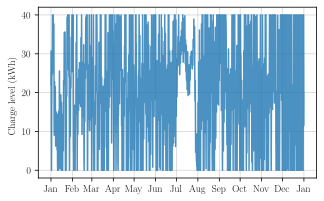

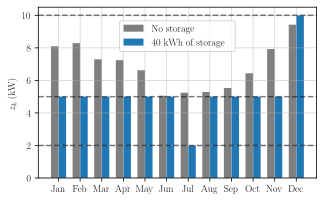

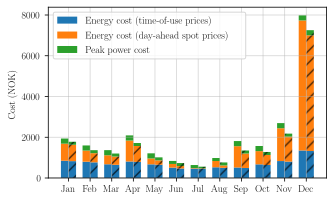

In [5]:
# Plot grid power with and without storage over the whole year
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, load, color="tab:gray", label="No storage")
ax.plot(sim_datetime_index, p_prescient, color="tab:blue", alpha=0.8, label="40 kWh of storage")
ax.axhline(2, color='black', linestyle='dashed', alpha=0.5) 
ax.axhline(5, color='black', linestyle='dashed', alpha=0.5) 
ax.axhline(10, color='black', linestyle='dashed', alpha=0.5)
plt.ylabel("Grid power (kW)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("figures/p_prescient.pdf")

# Plot charge level over the whole year
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, q_prescient[1:], color="tab:blue", alpha=0.8)
plt.ylabel("Charge level (kWh)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("figures/q_prescient.pdf")

# Plot z values (monthly average of N largest maximum daily powers) over the whole year
z_load = get_z_values(power=load, datetime_index=sim_datetime_index, N=3)
z_prescient = get_z_values(power=p_prescient, datetime_index=sim_datetime_index, N=3)

fig, ax = plt.subplots()
bar_width = 0.35
bar_offset = bar_width / 2
plt.bar(months - bar_offset, z_load, bar_width, color="tab:gray", label="No storage")
plt.bar(months + bar_offset, z_prescient, bar_width, color="tab:blue", label="40 kWh of storage")
ax.axhline(2, color='black', linestyle='dashed', alpha=0.5) 
ax.axhline(5, color='black', linestyle='dashed', alpha=0.5) 
ax.axhline(10, color='black', linestyle='dashed', alpha=0.5)
plt.xticks(months, [calendar.month_abbr[m] for m in range(1, 13)])
plt.ylabel('$z_k$ (kW)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95))
plt.savefig("figures/z_prescient.pdf")

# Plot monthly costs with and woithout storage over the whole year
monthly_tou_costs_prescient, monthly_spot_costs_prescient, monthly_peak_costs_prescient, tou_cost_prescient, spot_cost_prescient, peak_cost_prescient = compute_costs(tou_prices, spot_prices, p_prescient, sim_datetime_index)
cost_prescient = tou_cost_prescient + spot_cost_prescient + peak_cost_prescient
print_cost_summary(tou_cost_prescient, spot_cost_prescient, peak_cost_prescient)

fig, ax = plt.subplots()
bar_width = 0.35
bar_offset = bar_width / 2
plt.bar(months - bar_offset, monthly_tou_costs, bar_width, color="tab:blue", label='Energy cost (time-of-use prices)')
plt.bar(months - bar_offset, monthly_spot_costs, bar_width, bottom=monthly_tou_costs, color="tab:orange", label='Energy cost (day-ahead spot prices)')
plt.bar(months - bar_offset, monthly_peak_costs, bar_width, bottom=[i+j for i,j in zip(monthly_tou_costs, monthly_spot_costs)], color="tab:green", label='Peak power cost')
plt.bar(months + bar_offset, monthly_tou_costs_prescient, bar_width, color="tab:blue", hatch='//')
plt.bar(months + bar_offset, monthly_spot_costs_prescient, bar_width, bottom=monthly_tou_costs_prescient, color="tab:orange", hatch='//')
plt.bar(months + bar_offset, monthly_peak_costs_prescient, bar_width, bottom=[i+j for i,j in zip(monthly_tou_costs_prescient, monthly_spot_costs_prescient)], color="tab:green", hatch='//')
plt.xticks(months, [calendar.month_abbr[m] for m in range(1, 13)])
plt.ylabel('Cost (NOK)')
plt.legend(loc="upper left")
plt.savefig("figures/cost_prescient.pdf")

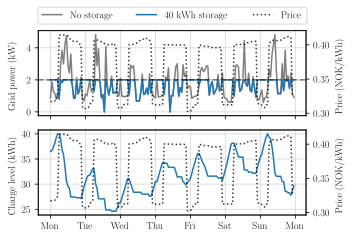

In [6]:
# Deatiled view of one week in January 2022
p_series = pd.Series(p_prescient, index=sim_datetime_index)
l_series = pd.Series(load, index=sim_datetime_index)
q_series = pd.Series(q_prescient[1:], index=sim_datetime_index)
price_series = pd.Series(spot_prices + tou_prices, index=sim_datetime_index)

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(l_series['2022-07-04':'2022-07-10'].values, color="tab:grey", label="No storage")
ax[0].plot(p_series['2022-07-04':'2022-07-10'].values, color="tab:blue", label="40 kWh storage")
ax[0].axhline(2, color='black', linestyle='dashed', alpha=0.5)
ax[0].set_ylabel("Grid power (kW)")

ax[1].plot(q_series['2022-07-04':'2022-07-10'].values)
ax[1].set_ylabel("Charge level (kWh)")
ax[1].set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax[1].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

ax2_list = []
for axis in ax:
    ax2 = axis.twinx()
    ax2.plot(price_series['2022-07-04':'2022-07-10'].values, color="k", alpha=0.8, linestyle="dotted", label="Price")
    ax2.set_ylabel("Price (NOK/kWh)")
    ax2.yaxis.tick_right()
    ax2.grid(False)
    ax2_list.append(ax2)

# Align y-axis labels
fig.align_ylabels(ax)
plt.tight_layout()

# Create legend box
handles, labels = ax[0].get_legend_handles_labels()
handles2, labels2 = ax2_list[0].get_legend_handles_labels()
all_handles = handles + handles2
all_labels = labels + labels2

fig.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.49, 1.08), ncol=3)

plt.savefig("figures/prescient_week.pdf")


### Cost versus storage capacity

100%|██████████| 50/50 [03:40<00:00,  4.40s/it]


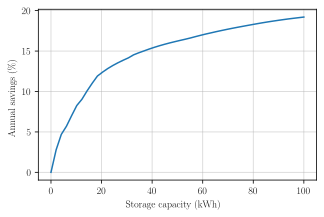

In [7]:
storage_capacities = np.linspace(0, 100)
costs = np.zeros_like(storage_capacities)
    
for i, Q in tqdm.tqdm(enumerate(storage_capacities), total=len(storage_capacities)):
    p, q, _, _, cost, _ = optimize(load=load, tou_prices=tou_prices, spot_prices=spot_prices, T=T, datetime_index=sim_datetime_index, Q=Q, C=Q/2, D=Q/2, q_init=Q/2, q_final=Q/2)
    costs[i] = cost
    
savings_percetage = (costs[0] - costs)/costs[0] * 100

plt.figure()
plt.plot(storage_capacities, savings_percetage, color="tab:blue", linestyle="solid")
plt.xlabel("Storage capacity (kWh)")
plt.ylabel("Annual savings (\%)")

plt.savefig("figures/cost_vs_storage_capacity.pdf")

## Model predictive control with baseline-residual forecast

In [8]:
# t = 50
# M, L = 24, 23
# H = 24*2
# K = 1
# load_forecast = make_load_forecast(load_data=load_data, load_baseline=load_baseline, AR_params=AR_params, sim_start_time=sim_start_time, t=t, H=H, M=M, L=L, K=K, sigma_residual_errors=sigma_residual_errors)

# plt.plot(load_forecast)

In [9]:
# Constants
eff_s, eff_c, eff_d = 0.99998, 0.95, 0.95
q_init = 20
M, L = 24, 23
H = 24*30

# Simulation window
T = 24*365

# Empty arrays to store results
p_mpc = np.zeros(T)
q_mpc = np.zeros(T+1)
p_prev = []

# Initial conditions
q_mpc[0] = q_init
prev_datetime = sim_datetime_index[0]

# MPC loop
for t in tqdm.trange(T):
    
    # Reset p_prev if new month
    if prev_datetime.month != sim_datetime_index[t].month:
        p_prev = []
    
    # Make forecasts
    load_forecast = make_load_forecast(load_data, load_baseline, AR_params, sim_start_time, t, H, M, L, MIN, MAX)
    spot_price_forecast = make_spot_price_forecast(spot_price_data, sim_datetime_index, sim_start_time, t, H)
    tou_price_forecast = tou_price_data[sim_start_time+t:sim_start_time+t+H].values
    
    # Get datetime index for the planning horizon and for the hours in the current month so far
    datetime_index_horizon = load_baseline.index[sim_start_time+t:sim_start_time+t+H]
    datetime_index_prev = sim_datetime_index[(sim_datetime_index.month == sim_datetime_index[t].month) & (sim_datetime_index < sim_datetime_index[t])]
    
    # Optimize (plan sequence of actions) over a horizon
    p, _, c, d, _, _ = optimize(load=load_forecast, tou_prices=tou_price_forecast, spot_prices=spot_price_forecast, T=H, datetime_index=datetime_index_horizon,
                       q_init=q_mpc[t], p_prev=p_prev, datetime_index_prev=datetime_index_prev)
    # p, _, c, d, _, _ = relax_and_resolve(load=load_forecast, tou_prices=tou_price_forecast, spot_prices=spot_price_forecast, T=H, datetime_index=datetime_index_horizon,
    #                    q_init=q_mpc[t], p_prev=p_prev, datetime_index_prev=datetime_index_prev)
    
    # Execute first action in the plan
    p_mpc[t] = p[0]
    q_mpc[t+1] =  eff_s * q_mpc[t] + eff_c * c[0] - (1/eff_d) * d[0]
    prev_datetime = sim_datetime_index[t]
    p_prev.append(p[0])

100%|██████████| 8760/8760 [24:58<00:00,  5.85it/s]


Total cost: 21,771.43 NOK
	Energy cost related to time-of-use prices: 8,196.79 NOK (37.65% of total cost)
	Energy cost related to day-ahead spot prices: 10,970.64 NOK (50.39% of total cost)
	Peak power cost: 2,604.00 NOK (11.96% of total cost)



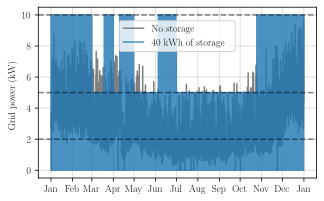

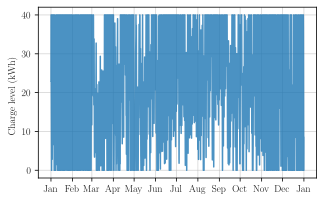

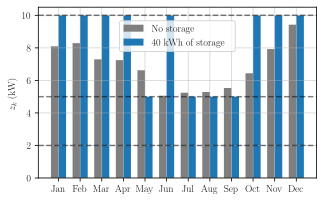

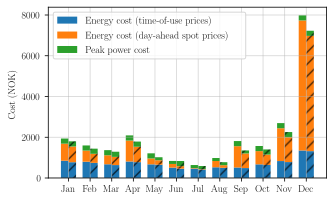

In [10]:
# Plot grid power with and without storage over the whole year
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, load, color="tab:gray", label="No storage")
ax.plot(sim_datetime_index, p_mpc, color="tab:blue", alpha=0.8, label="40 kWh of storage")
ax.axhline(2, color='black', linestyle='dashed', alpha=0.5) 
ax.axhline(5, color='black', linestyle='dashed', alpha=0.5) 
ax.axhline(10, color='black', linestyle='dashed', alpha=0.5)
plt.ylabel("Grid power (kW)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("figures/p_mpc.pdf")

# Plot charge level over the whole year
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, q_mpc[1:], color="tab:blue", alpha=0.8)
plt.ylabel("Charge level (kWh)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.savefig("figures/q_mpc.pdf")

# Plot z values (monthly average of N largest maximum daily powers) over the whole year
z_load = get_z_values(power=load, datetime_index=sim_datetime_index, N=3)
z_mpc = get_z_values(power=p_mpc, datetime_index=sim_datetime_index, N=3)

fig, ax = plt.subplots()
bar_width = 0.35
bar_offset = bar_width / 2
plt.bar(months - bar_offset, z_load, bar_width, color="tab:gray", label="No storage")
plt.bar(months + bar_offset, z_mpc, bar_width, color="tab:blue", label="40 kWh of storage")
ax.axhline(2, color='black', linestyle='dashed', alpha=0.5) 
ax.axhline(5, color='black', linestyle='dashed', alpha=0.5) 
ax.axhline(10, color='black', linestyle='dashed', alpha=0.5)
plt.xticks(months, [calendar.month_abbr[m] for m in range(1, 13)])
plt.ylabel('$z_k$ (kW)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95))
plt.savefig("figures/z_mpc.pdf")

# Plot monthly costs with and woithout storage over the whole year
monthly_tou_costs_mpc, monthly_spot_costs_mpc, monthly_peak_costs_mpc, tou_cost_mpc, spot_cost_mpc, peak_cost_mpc = compute_costs(tou_prices, spot_prices, p_mpc, sim_datetime_index)
cost_mpc = tou_cost_mpc + spot_cost_mpc + peak_cost_mpc
print_cost_summary(tou_cost_mpc, spot_cost_mpc, peak_cost_mpc)

fig, ax = plt.subplots()
bar_width = 0.35
bar_offset = bar_width / 2
plt.bar(months - bar_offset, monthly_tou_costs, bar_width, color="tab:blue", label='Energy cost (time-of-use prices)')
plt.bar(months - bar_offset, monthly_spot_costs, bar_width, bottom=monthly_tou_costs, color="tab:orange", label='Energy cost (day-ahead spot prices)')
plt.bar(months - bar_offset, monthly_peak_costs, bar_width, bottom=[i+j for i,j in zip(monthly_tou_costs, monthly_spot_costs)], color="tab:green", label='Peak power cost')
plt.bar(months + bar_offset, monthly_tou_costs_mpc, bar_width, color="tab:blue", hatch='//')
plt.bar(months + bar_offset, monthly_spot_costs_mpc, bar_width, bottom=monthly_tou_costs_mpc, color="tab:orange", hatch='//')
plt.bar(months + bar_offset, monthly_peak_costs_mpc, bar_width, bottom=[i+j for i,j in zip(monthly_tou_costs_mpc, monthly_spot_costs_mpc)], color="tab:green", hatch='//')
plt.xticks(months, [calendar.month_abbr[m] for m in range(1, 13)])
plt.ylabel('Cost (NOK)')
plt.legend()
plt.savefig("figures/cost_mpc.pdf")

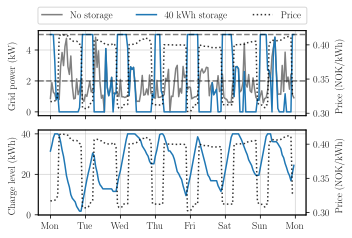

In [11]:
# Deatiled view of one week in January 2022
p_series = pd.Series(p_mpc, index=sim_datetime_index)
l_series = pd.Series(load, index=sim_datetime_index)
q_series = pd.Series(q_mpc[1:], index=sim_datetime_index)
price_series = pd.Series(spot_prices + tou_prices, index=sim_datetime_index)

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(l_series['2022-07-04':'2022-07-10'].values, color="gray", label="No storage")
ax[0].plot(p_series['2022-07-04':'2022-07-10'].values, color="tab:blue", label="40 kWh storage")
ax[0].axhline(2, color='black', linestyle='dashed', alpha=0.5)
ax[0].axhline(5, color='black', linestyle='dashed', alpha=0.5)
ax[0].set_ylabel("Grid power (kW)")

ax[1].plot(q_series['2022-07-04':'2022-07-10'].values)
ax[1].set_ylabel("Charge level (kWh)")
ax[1].set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax[1].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

ax2_list = []
for axis in ax:
    ax2 = axis.twinx()
    ax2.plot(price_series['2022-07-04':'2022-07-10'].values, color="k", alpha=0.8, linestyle="dotted", label="Price")
    ax2.set_ylabel("Price (NOK/kWh)")
    ax2.yaxis.tick_right()
    ax2.grid(False)
    ax2_list.append(ax2)

# Align y-axis labels
fig.align_ylabels(ax)
plt.tight_layout()

# Create legend box
handles, labels = ax[0].get_legend_handles_labels()
handles2, labels2 = ax2_list[0].get_legend_handles_labels()
all_handles = handles + handles2
all_labels = labels + labels2

fig.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.49, 1.08), ncol=3)

plt.savefig("figures/mpc_week.pdf")

## Multi-forecast model predictive control

In [12]:
# # Constants
# eff_s, eff_c, eff_d = 0.99998, 0.95, 0.95
# q_init = 20
# M, L = 24, 23
# H = 24*30

# # Simulation window
# T = 24*10

# # Constants
# K = 10

# # Empty arrays to store results
# p_mpc = np.zeros(T)
# q_mpc = np.zeros(T+1)
# p_prev = []

# # Initial conditions
# q_mpc[0] = q_init
# prev_datetime = sim_datetime_index[0]

# # MPC loop
# for t in tqdm.trange(T):
    
#     # Reset p_prev if new month
#     if prev_datetime.month != sim_datetime_index[t].month:
#         p_prev = []
    
#     # Make forecasts
#     load_forecast = make_load_forecast(load_data=load_data, load_baseline=load_baseline, AR_params=AR_params, sim_start_time=sim_start_time, t=t, H=H, M=M, L=L, K=K, sigma_residual_errors=sigma_residual_errors)
#     spot_price_forecast = make_spot_price_forecast(spot_price_data, sim_datetime_index, sim_start_time, t, H)
#     tou_price_forecast = tou_price_data[sim_start_time+t:sim_start_time+t+H].values
    
#     # Get datetime index for the planning horizon and for the hours in the current month so far
#     datetime_index_horizon = load_baseline.index[sim_start_time+t:sim_start_time+t+H]
#     datetime_index_prev = sim_datetime_index[(sim_datetime_index.month == sim_datetime_index[t].month) & (sim_datetime_index < sim_datetime_index[t])]
    
#     # Optimize (plan sequence of actions) over a horizon
#     p, _, c, d, _, _ = optimize(load=load_forecast, tou_prices=tou_price_forecast, spot_prices=spot_price_forecast, T=H, datetime_index=datetime_index_horizon,
#                        q_init=q_mpc[t], p_prev=p_prev, datetime_index_prev=datetime_index_prev, K=K)
#     # p, _, c, d, _, _ = relax_and_resolve(load=load_forecast, tou_prices=tou_price_forecast, spot_prices=spot_price_forecast, T=H, datetime_index=datetime_index_horizon,
#     #                    q_init=q_mpc[t], p_prev=p_prev, datetime_index_prev=datetime_index_prev)
#     print(p[0,0])
#     print(c[0,0])
#     print(d[0,0])
#     # Execute first action in the plan
#     p_mpc[t] = p[0,0]
#     q_mpc[t+1] =  eff_s * q_mpc[t] + eff_c * c[0,0] - (1/eff_d) * d[0,0]
#     prev_datetime = sim_datetime_index[t]
#     p_prev.append(p[0,0])
    
#     print(p_mpc)
#     print(q_mpc)
#     print(p_prev)

#### Cost comparison

In [13]:
print(f"Cost without storage: {cost_no_storage:,.2f} NOK")
print(f"Cost with 40 kWh of storage capacity and perfect forecast (prescient bound): {cost_prescient:,.2f} NOK")
print(f"Cost with 40 kWh of storage capacity and MPC policy: {cost_mpc:,.2f} NOK")

relative_gap = (abs(cost_mpc - cost_prescient) / abs(cost_prescient)) * 100
print(f"Relative gap between MPC cost and prescient bound: {relative_gap:.2f}%")
print(f"Annual savings with MPC policy and 40 kWh of storage capacity: {cost_no_storage-cost_mpc:.2f} NOK ({100 * (cost_no_storage-cost_mpc) / cost_no_storage:.2f}%)")

Cost without storage: 24,722.07 NOK
Cost with 40 kWh of storage capacity and perfect forecast (prescient bound): 21,188.23 NOK
Cost with 40 kWh of storage capacity and MPC policy: 21,771.43 NOK
Relative gap between MPC cost and prescient bound: 2.75%
Annual savings with MPC policy and 40 kWh of storage capacity: 2950.64 NOK (11.94%)
